In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
#from transformers import RobertaTokenizer, TFRobertaModel
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
MODEL_NAME = 'jackaduma/SecRoBERTa'  # Update this to the correct SecRoBERTa model name
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [4]:
df = pd.read_csv('/kaggle/input/mitre-website-scraped/Mitre_Website_Scraped - Mitre_Website_Scraped.csv')
df.head()

,Unnamed: 0,Technique,ID,Tactic-Name,Technique-Name,SubTechnique-Name,Platforms,Description
0,0,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",admin@338 actors used the following command fo...
1,1,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",Andariel has used the netstat -naop tcp comman...
2,2,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT1 used the net use command to get a listing...
3,3,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT3 has a tool that can enumerate current net...
4,4,T1049,No sub-Techniques,Discovery,System Network Connections Discovery,No sub-Technique,"IaaS, Linux, Network, Windows, macOS",APT32 used the netstat -anpo tcp command to di...


In [5]:
X_data = df[['Description']].to_numpy().reshape(-1)
y_data = df[['ID']].to_numpy().reshape(-1)

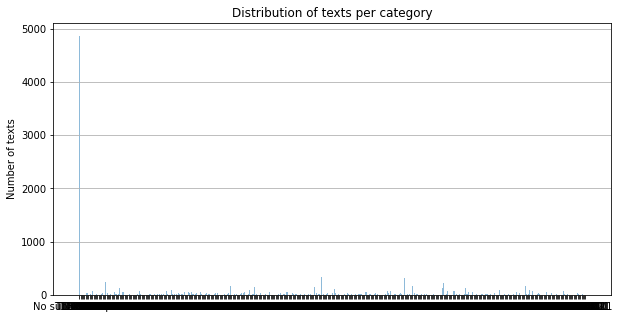

Counter({'No sub-Techniques': 4862, 'T1071.001': 329, 'T1059.003': 322, 'T1070.004': 243, 'T1547.001': 227, 'T1059.001': 173, 'T1036.005': 165, 'T1204.002': 162, 'T1573.001': 146, 'T1053.005': 145, 'T1056.001': 136, 'T1566.001': 126, 'T1543.003': 119, 'T1059.005': 113, 'T1132.001': 97, 'T1074.001': 95, 'T1218.011': 89, 'T1027.002': 88, 'T1588.002': 80, 'T1562.001': 78, 'T1036.004': 76, 'T1555.003': 71, 'T1566.002': 68, 'T1204.001': 68, 'T1573.002': 64, 'T1553.002': 62, 'T1636.004': 62, 'T1055.001': 61, 'T1003.001': 60, 'T1027.010': 59, 'T1560.001': 58, 'T1569.002': 57, 'T1574.002': 55, 'T1497.001': 54, 'T1548.002': 52, 'T1087.001': 50, 'T1071.004': 50, 'T1564.001': 48, 'T1102.002': 46, 'T1021.002': 46, 'T1636.003': 46, 'T1070.006': 45, 'T1021.001': 45, 'T1059.007': 44, 'T1087.002': 42, 'T1497.003': 41, 'T1583.001': 40, 'T1564.003': 40, 'T1437.001': 40, 'T1059.006': 38, 'T1560.003': 37, 'T1027.001': 36, 'T1505.003': 33, 'T1636.002': 33, 'T1218.010': 31, 'T1059.004': 31, 'T1055.012': 31,

In [6]:
categories = df[['ID']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [7]:
def calculate_stats(df, split_char=' '):
    categories = df['ID'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Description']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['ID']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['ID'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [8]:
#df_stats = calculate_stats(df)
#df_stats['per_category']

In [9]:
#display_lengths_histograms(df_stats)

In [10]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['ID'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 11785
Number of categories: 390
Done!


# Tokenize & encode

In [11]:
def secroberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [12]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'No sub-Techniques',
 1: 'T1218.012',
 2: 'T1574.007',
 3: 'T1562.002',
 4: 'T1484.002',
 5: 'T1204.003',
 6: 'T1583.001',
 7: 'T1069.003',
 8: 'T1591.001',
 9: 'T1036.008',
 10: 'T1573.002',
 11: 'T1134.004',
 12: 'T1098.004',
 13: 'T1583.006',
 14: 'T1137.003',
 15: 'T1552.003',
 16: 'T1592.002',
 17: 'T1090.002',
 18: 'T1087.002',
 19: 'T1584.005',
 20: 'T1070.004',
 21: 'T1552.008',
 22: 'T1059.006',
 23: 'T1584.002',
 24: 'T1056.002',
 25: 'T1087.004',
 26: 'T1499.004',
 27: 'T1574.002',
 28: 'T1102.001',
 29: 'T1021.006',
 30: 'T1027.004',
 31: 'T1566.001',
 32: 'T1568.003',
 33: 'T1560.001',
 34: 'T1027.010',
 35: 'T1037.005',
 36: 'T1584.006',
 37: 'T1052.001',
 38: 'T1588.005',
 39: 'T1588.001',
 40: 'T1137.005',
 41: 'T1213.003',
 42: 'T1553.005',
 43: 'T1598.002',
 44: 'T1552.006',
 45: 'T1587.001',
 46: 'T1555.003',
 47: 'T1110.002',
 48: 'T1574.011',
 49: 'T1565.002',
 50: 'T1563.002',
 51: 'T1059.009',
 52: 'T1550.001',
 53: 'T1218.004',
 54: 'T1021.005',
 55: 'T1132.

In [13]:
# Split into train and test datasets
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [14]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
# Split into train and test datasets using StratifiedKFold to ensure 70% train and 30% test for each category
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=777)  # 10 splits for 70%-30%

# Ensure y_data is a NumPy array of integers
y_data = np.asarray(y_data, dtype='int32')
# Combine X_data and y_data for stratified splitting
data = list(zip(X_data, y_data))

# Create train and test splits using the stratified split
train_indices, test_indices = next(skf.split(X_data, y_data))

X_train = X_data[train_indices]
X_test = X_data[test_indices]
y_train = y_data[train_indices]
y_test = y_data[test_indices]

# Print the shapes to verify
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training set: X_train shape: (10606,), y_train shape: (10606,)
Test set: X_test shape: (1179,), y_test shape: (1179,)


In [15]:
# Combine X_train and y_train into a DataFrame
train_df = pd.DataFrame({'Description': X_train, 'ID': y_train})

# Combine X_test and y_test into a DataFrame
test_df = pd.DataFrame({'Description': X_test, 'ID': y_test})

# Save the training set to a CSV file
train_df.to_csv('train_set.csv', index=False)

# Save the testing set to a CSV file
test_df.to_csv('test_set.csv', index=False)

print("Training and testing sets have been saved to 'train_set.csv' and 'test_set.csv' respectively.")


Training and testing sets have been saved to 'train_set.csv' and 'test_set.csv' respectively.


In [16]:
# Import tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)


Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/451k [00:00<?, ?B/s]

In [17]:
X_train = secroberta_encode(X_train, tokenizer)
X_test = secroberta_encode(X_test, tokenizer)
y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create secRoBERTa

In [18]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import SecRoBERTa model from HuggingFace with PyTorch weights
        secroberta_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=n_categories, from_pt=True)
        x = secroberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        return model


In [19]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/321M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 83750790    input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [20]:
# Import tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



In [27]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=12,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/12
1326/1326 [==============================] - 320s 241ms/step - loss: 0.2610 - accuracy: 0.9480 - val_loss: 1.3992 - val_accuracy: 0.7744
Epoch 2/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.2166 - accuracy: 0.9566 - val_loss: 1.4106 - val_accuracy: 0.7735
Epoch 3/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.1749 - accuracy: 0.9660 - val_loss: 1.4304 - val_accuracy: 0.7735
Epoch 4/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.1483 - accuracy: 0.9707 - val_loss: 1.4442 - val_accuracy: 0.7761
Epoch 5/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.1314 - accuracy: 0.9731 - val_loss: 1.4592 - val_accuracy: 0.7752
Epoch 6/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.0985 - accuracy: 0.9808 - val_loss: 1.4866 - val_accuracy: 0.7727
Epoch 7/12
1326/1326 [==============================] - 319s 241ms/step - loss: 0.0892 - accuracy: 0

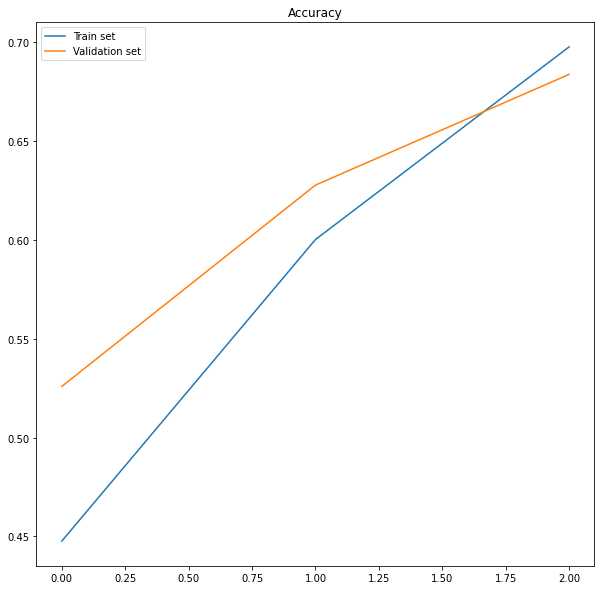

In [22]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [23]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 68.36%


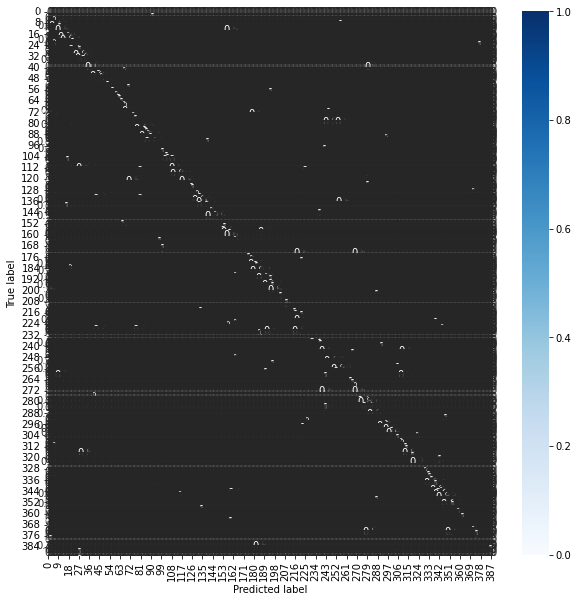

In [29]:
plot_confusion_matrix(X_test, y_test, model)

In [30]:
model.save('secRoberta.keras')